<a href="https://colab.research.google.com/github/nhtanhdang/Data-Analysis-with-Python/blob/main/hospitalization_hypothesis_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Apollo Hospitals was established in 1983, renowned as the architect of modern healthcare in India. As the nation's first corporate hospital, Apollo Hospitals is acclaimed for pioneering the private healthcare revolution in the country.

**The company wants to know:**

1. Which variables are significant in predicting the hospitalization charges for different regions;
2. How well some variables like viral load, smoking, and severity level describe the hospitalization charges;

**Data Description**

The file apollo_data.csv contains anonymized data of COVID-19 hospital patients and contains the following variables:

1. age - an integer indicating the age of the primary beneficiary (excluding those above 64 years, since they are generally covered by the government)
2. sex - the policy holder's gender, either male or female
3. smoker - 'yes' or 'no' depending on whether the insured regularly smokes tobacco
region - beneficiary's place of residence in Delhi, divided into four geographic regions - northeast, southeast, southwest, or northwest
4. viral load - the amount of virus in an infected person's blood
5. severity level - an integer indicating how severe the patient is
6. hospitalization charges - individual medical costs billed to health insurance

**Answer**
1. To decide which variables are significant in predicting hospitalization charges (DV) for different regions, we should fit the regression model (OLS) first and then examine the normality of the residuals as OLS assumes this.

In [1]:
# Import libraries and mount Google Drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
from google.colab import drive
drive.mount('/content/drive')

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

from statsmodels.stats.outliers_influence import variance_inflation_factor

Mounted at /content/drive


In [2]:
# Read dataset
path_to_data = '/content/drive/MyDrive/Colab-Notebooks/data/apollo_data.csv'
df = pd.read_csv(path_to_data)
df.head()

,Unnamed: 0,age,sex,smoker,region,viral load,severity level,hospitalization charges
0,0,19,female,yes,southwest,9.30,0,42212
1,1,18,male,no,southeast,11.26,1,4314
2,2,28,male,no,southeast,11.00,3,11124
3,3,33,male,no,northwest,7.57,0,54961
4,4,32,male,no,northwest,9.63,0,9667


**Descriptive Analytics**

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               1338 non-null   int64  
 1   age                      1338 non-null   int64  
 2   sex                      1338 non-null   object 
 3   smoker                   1338 non-null   object 
 4   region                   1338 non-null   object 
 5   viral load               1338 non-null   float64
 6   severity level           1338 non-null   int64  
 7   hospitalization charges  1338 non-null   int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 83.8+ KB


In [4]:
df.describe()

,Unnamed: 0,age,viral load,severity level,hospitalization charges
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,668.500000,39.207025,10.221233,1.094918,33176.058296
std,386.391641,14.049960,2.032796,1.205493,30275.029296
min,0.000000,18.000000,5.320000,0.000000,2805.000000
25%,334.250000,27.000000,8.762500,0.000000,11851.000000
50%,668.500000,39.000000,10.130000,1.000000,23455.000000
75%,1002.750000,51.000000,11.567500,2.000000,41599.500000
max,1337.000000,64.000000,17.710000,5.000000,159426.000000


In [24]:
# Check categorical values
cat_columns = df.columns[df.dtypes == 'object']
for col in cat_columns:
  print(f"{col}: {df[col].unique()}")

sex: ['female' 'male']
smoker: ['yes' 'no']
region: ['southwest' 'southeast' 'northwest' 'northeast']


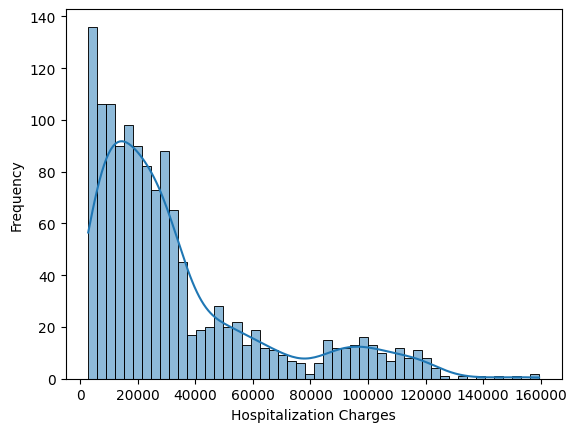

In [5]:
sns.histplot(df['hospitalization charges'], bins=50, kde=True)
plt.xlabel('Hospitalization Charges')
plt.ylabel('Frequency')
plt.show()

In [54]:
# Data preparation
df_processed = df.drop(columns=['Unnamed: 0'])

df_processed['sex_encoded'] = df_processed['sex'].map({'male': 0, 'female': 1})
df_processed['smoker_encoded'] = df_processed['smoker'].map({'no': 0, 'yes': 1})
df_processed = df_processed.drop(columns=['sex', 'smoker'])

# Encode regions
df_encoded = pd.get_dummies(df_processed, columns=['region'], drop_first=True)

for col in ['region_southwest', 'region_southeast', 'region_northwest']:
  df_encoded[col] = df_encoded[col].astype(int)

In [25]:
df_encoded.head()

,age,viral load,severity level,hospitalization charges,sex_encoded,smoker_encoded,region_northwest,region_southeast,region_southwest
0,19,9.30,0,42212,1,1,0,0,1
1,18,11.26,1,4314,0,0,0,1,0
2,28,11.00,3,11124,0,0,0,1,0
3,33,7.57,0,54961,0,0,1,0,0
4,32,9.63,0,9667,0,0,1,0,0


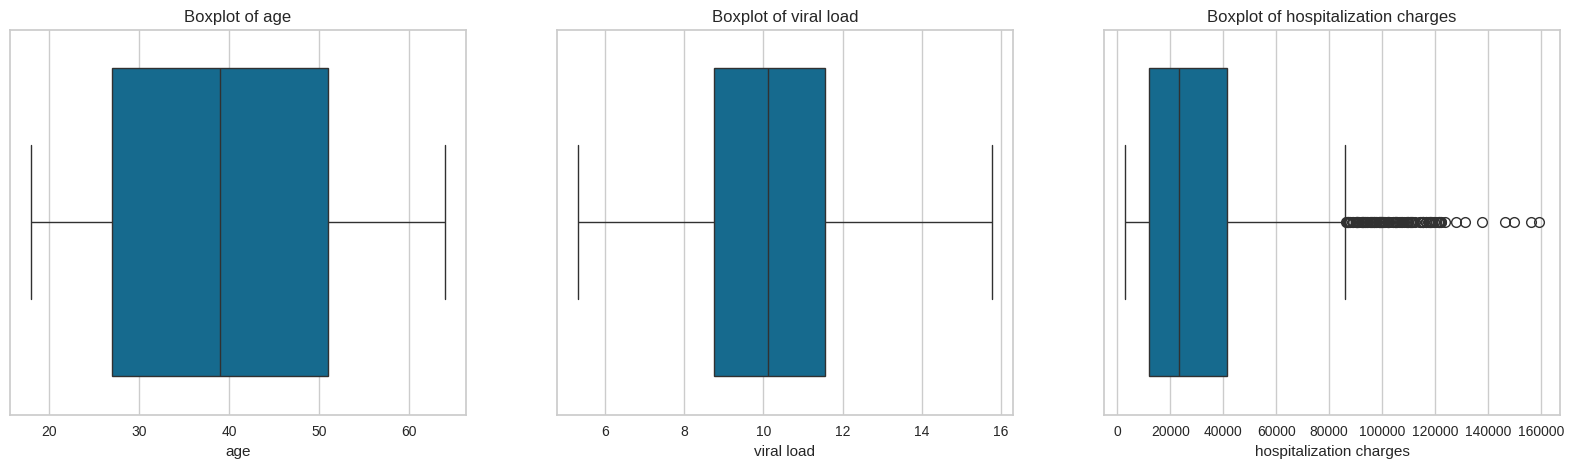

In [56]:
# Plot boxplot for each numerical variable to detect outliers
fig, axes = plt.subplots(ncols=3, figsize=(20, 5))
for i, col in enumerate(['age', 'viral load', 'hospitalization charges']):
    sns.boxplot(x=df_encoded[col], ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')
plt.show()

In [55]:
# Detect & Handle outliers in viral load
load_IQR = df_encoded['viral load'].quantile(0.75) - df_encoded['viral load'].quantile(0.25)
load_lower_bound = df_encoded['viral load'].quantile(0.25) - (1.5 * load_IQR)
load_upper_bound = df_encoded['viral load'].quantile(0.75) + (1.5 * load_IQR)

# Calculate number of outliers
outliers_below = df_encoded['viral load'] < load_lower_bound
outliers_above = df_encoded['viral load'] > load_upper_bound

# Total number of outliers
total_outliers = outliers_below.sum() + outliers_above.sum()

print(f"Number of outliers below lower bound: {outliers_below.sum()}")
print(f"Number of outliers above upper bound: {outliers_above.sum()}")
print(f"Total number of outliers: {total_outliers}")

# Capping
df_encoded.loc[df_encoded['viral load'] < load_lower_bound, 'viral load'] = load_lower_bound
df_encoded.loc[df_encoded['viral load'] > load_upper_bound, 'viral load'] = load_upper_bound

Number of outliers below lower bound: 0
Number of outliers above upper bound: 9
Total number of outliers: 9


In [43]:
# Detect outliers in hospitalization charges
charges_IQR = df_encoded['hospitalization charges'].quantile(0.75) - df_encoded['hospitalization charges'].quantile(0.25)
charges_lower_bound = df_encoded['hospitalization charges'].quantile(0.25) - (1.5 * charges_IQR)
charges_upper_bound = df_encoded['hospitalization charges'].quantile(0.75) + (1.5 * charges_IQR)

# Calculate number of outliers
outliers_below = df_encoded['hospitalization charges'] < charges_lower_bound
outliers_above = df_encoded['hospitalization charges'] > charges_upper_bound

# Total number of outliers
total_outliers = outliers_below.sum() + outliers_above.sum()

print(f"Number of outliers below lower bound: {outliers_below.sum()}")
print(f"Number of outliers above upper bound: {outliers_above.sum()}")
print(f"Total number of outliers: {total_outliers}")

Number of outliers below lower bound: 0
Number of outliers above upper bound: 139
Total number of outliers: 139


<ipython-input-43-dd76db2c7fff>:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-32771.75' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_encoded.loc[df_encoded['hospitalization charges'] < charges_lower_bound, 'hospitalization charges'] = charges_lower_bound


Comment: After experimenting different model settings, fitting the model with capped response term affects the model's ability to predict large hospitalization charges.

In [57]:
# 1. Split IVs and DV
X = df_encoded.drop(columns=['hospitalization charges'])
y = df_encoded['hospitalization charges']

# 2. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

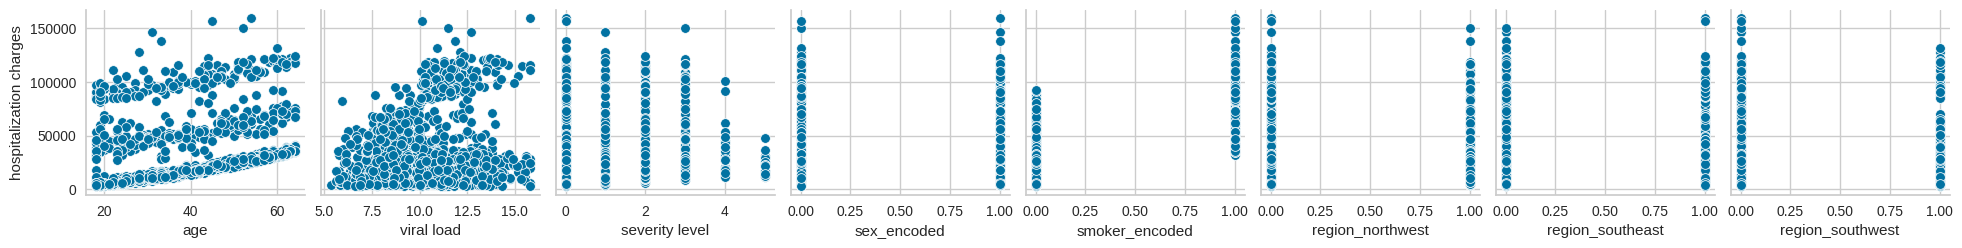

In [58]:
# 3. Plot each IVs to DV to examine the linearity of their relationships
sns.pairplot(df_encoded, x_vars=X.columns, y_vars='hospitalization charges')
plt.show()

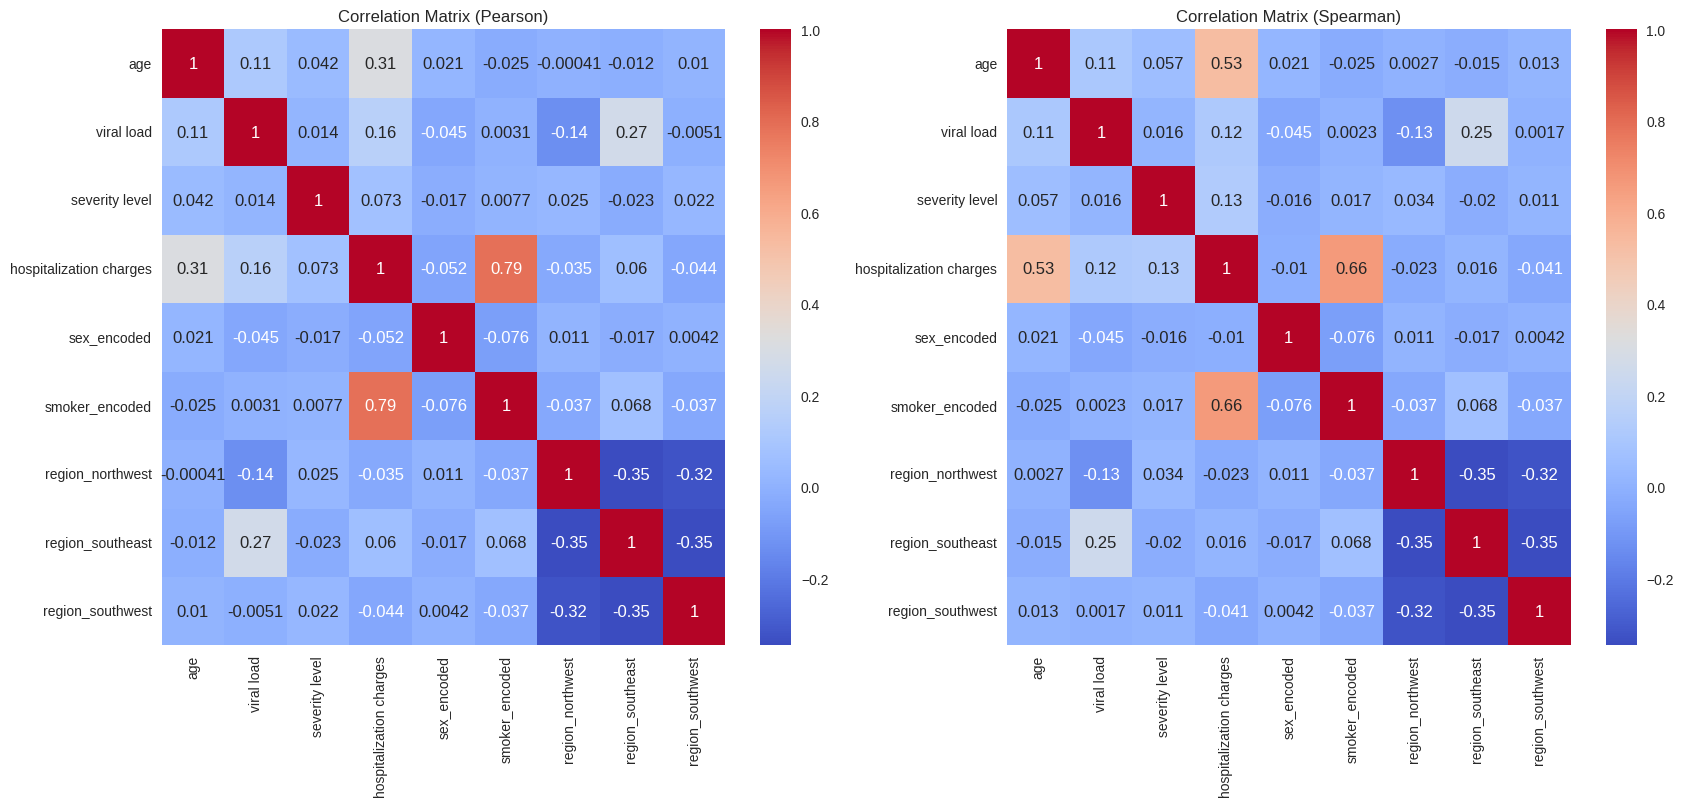

In [47]:
# 4. Use corellation metrics to evaluate linear relationships

# Pearson's r
corr_pearson = df_encoded.corr(method='pearson')

# Spearman's rho
corr_spearman = df_encoded.corr(method='spearman')

# Plot correlation using heatmap
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,8))

sns.heatmap(corr_pearson, annot=True, cmap='coolwarm', ax=axes[0])
axes[0].set_title('Correlation Matrix (Pearson)')

sns.heatmap(corr_spearman, annot=True, cmap='coolwarm', ax=axes[1])
axes[1].set_title('Correlation Matrix (Spearman)')

plt.show()

In [48]:
# 5. Use VIF to evaluate multicolinearity between variables - VIF accounts for all other variables, not just pairwise correlations like Pearson's r
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

vif_data = calculate_vif(X)
print(vif_data)

           Variable        VIF
0               age   7.800026
1        viral load  11.131242
2    severity level   1.808568
3       sex_encoded   1.916593
4    smoker_encoded   1.254759
5  region_northwest   1.895083
6  region_southeast   2.264834
7  region_southwest   1.964018


**Key insights about linearity of relationships between IVs and DV:**

**Pearson's r and Spearman's rho:**
- As the age of a patient increases, hospitalization charges tend to increase. The higher Spearman's correlation coefficient (0.53) compared to Pearson's (0.3) suggests that the relationship is monotonic but not strictly linear. This implies that while hospitalization charges generally rise with age, the rate of increase may vary.
- Whether a patient smokes or not shows a strong association with hospitalization charges, with a Pearson correlation of 0.79 indicating a strong positive linear relationship and a Spearman correlation of 0.66 suggesting a moderate positive monotonic relationship.
- Other independent variables, such as viral load, severity level, sex, and region, do not show a significant linear correlation with hospitalization charges, with Pearson or Spearman metrics generally below 0.2, suggesting weak or negligible associations.
- Since the correlation metrics between the independent variables are not significant (generally less than 0.2), we can, for now, reasonably assume that there is no multicollinearity present.

**VIF:**
- Viral load shows a VIF of 11.07, which is relatively high and indicates strong multicollinearity with one or more of the other variables. Therefore, we should consider using other methods that can effectively handle multicolinearity in the dataset.

**Approach 1:** Fit Ordinary Least Square line (Linear Regression)
- Null Hypothesis: None of the independent variables (X) have any effect on the dependent variable (y).
- Alternative Hypothesis: At least one of the the independent variables (X) has significant effect on the dependent variable (y).
- Assumption:
  + Linear relationships between IVs and DV
  + Normally distributed residuals (Homogeneity of Variance)
  + No significant multicolinearity between variables


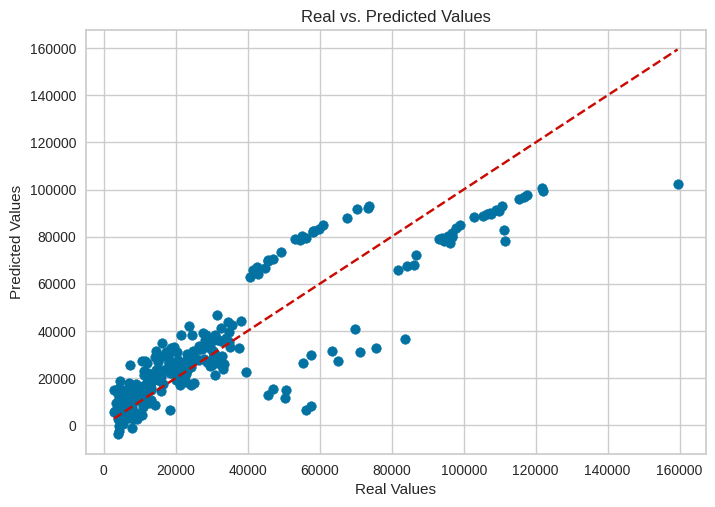

In [59]:
# Fit Least Squares estimator
model = LinearRegression()
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)

# Plot real vs. predicted response values
plt.scatter(y_test, y_test_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.title('Real vs. Predicted Values')
plt.show()

Observation: Looking at the graph, we can say that Linearity Assumption of the least squares estimator is met.

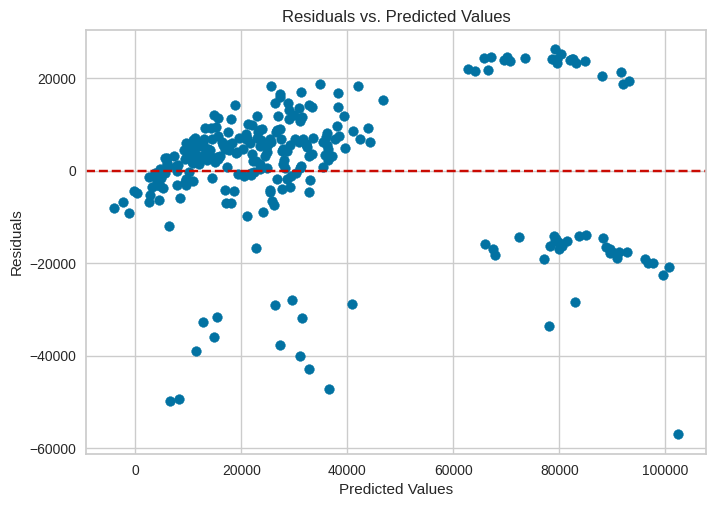

In [72]:
# Plot residuals vs. predicted values
residuals = y_test_pred - y_test
plt.scatter(y_test_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')
plt.show()

Observation: There are some discernible stripes of data for predicted values greater than 50,000. However, this may due to the lack of collected data. The variance appears to be relatively constant, albeit with some outliers.

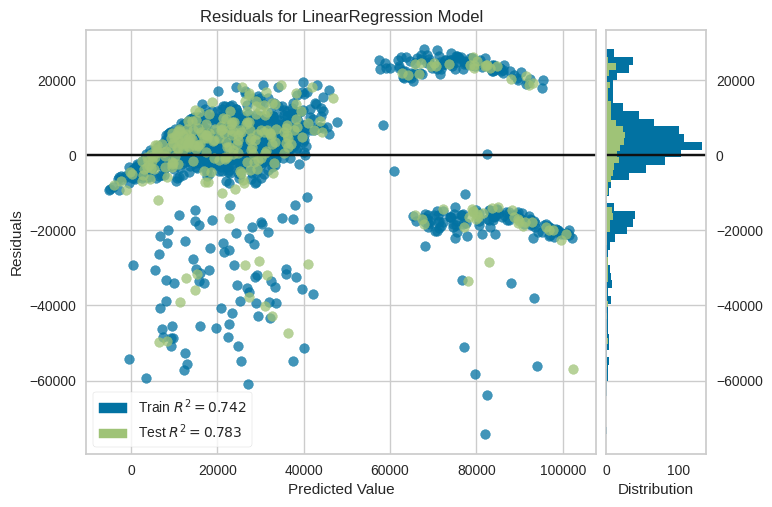

<Axes: title={'center': 'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [71]:
# 6. Examine distribution of residuals to verify the assumption
from yellowbrick.regressor import ResidualsPlot

model = LinearRegression()
visualizer = ResidualsPlot(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()

**Observations on Residuals:**
- There's a clear non-random pattern in the residuals, forming distinct "bands" or stripes in the data, suggesting a potential non-linear relationship that the model isn't capturing
- The residuals appear to fan out as predicted values increase, suggesting unequal variance
- The spread of residuals increases with higher predicted values, indicating the model's predictions become less reliable for larger values

In [73]:
# 7. Fit Linear Regression model and evaluate the performance on both train & test set to avoid overfitting
model_train = LinearRegression()
model_train.fit(X_train, y_train)

# Make predictions on the train & test set
y_train_pred = model_train.predict(X_train)
y_test_pred = model_train.predict(X_test)

# Performance on the training data
train_rmse = root_mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Performance on the test data
test_rmse = root_mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print results
print(f"Training RMSE: {train_rmse}, Training R²: {train_r2}")
print(f"Test RMSE: {test_rmse}, Test R²: {test_r2}")

Training RMSE: 15252.377733089883, Training R²: 0.7421141289885957
Test RMSE: 14521.930909261071, Test R²: 0.7826595257980555


**Conclusion:** The performance of the LR model through train and test set is relatively consistent, thus suggests no overfitting problem. Therefore, we can re-train the model with the entire dataset and draw conclusions from it.

In [74]:
# 8. Train the model with the entire dataset
X_sm = sm.add_constant(X)
sm_model = sm.OLS(y, X_sm)
sm_results = sm_model.fit()
print(sm_results.summary())

                               OLS Regression Results                              
Dep. Variable:     hospitalization charges   R-squared:                       0.751
Model:                                 OLS   Adj. R-squared:                  0.750
Method:                      Least Squares   F-statistic:                     501.1
Date:                     Sun, 05 Jan 2025   Prob (F-statistic):               0.00
Time:                             03:35:40   Log-Likelihood:                -14773.
No. Observations:                     1338   AIC:                         2.956e+04
Df Residuals:                         1329   BIC:                         2.961e+04
Df Model:                                8                                         
Covariance Type:                 nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

**Key Insights:**
- R-squared: 0.751 - The model explains 75.1% of the variance of hospitalization charges.

- F-score: 500.9, associated p-value converging to 0 - It strongly suggests that the model is statistically significant in predicting the DV, and provides evidence to reject the null hypothesis.

**Co-efficient Interpretation:**
- Some variables showing statistically significant impact (p-value <= .001) on predicting the hospitalization charges include age, viral load, severity level, smoker.

- For each one-year increase in age, hospitalization charges are expected to increase by 642.12 units, holding all other variables constant.

- For each unit increase in viral load, hospitalization charges are expected to increase by 2544.56 units, holding all other variables constant.

- For each one-unit increase in the severity level, hospitalization charges are expected to increase by 1188.88 units, holding all other variables constant.

- Whether the patient smokes or not is the most important factor in estimating the hospitalization charges. To be specific, on average, a smoker pays 59620 units more than a non-smoker.

- Some regions also show significant effect on the hospitalization charges (p-value < 0.05) compared to the omitted region - Northeast, including Southwest and Southeast region.

- Being in the Southeast region is associated with a decrease of 2,587.48 units in hospitalization charges compared to Northeast, while being in the Southwest region is associated with a decrease of 2,400.16.

- Sex does not appear to significantly affect hospitalization charges.

**95% Confidence Interval:**
- We are 95% confident that the hospitalization charge of a person is expected to increase between 583 to 700 units per year as their age increases.
- We are also 95% confident that with each unit increase in viral load, the patient's hospitalization costs are expected to increase by between 2124 and 2965 units.

**Approach 2:** Since the residuals show clear non-linear patterns when plotted against our DV, it suggests that our model has not fully captured the relationships between the IVs and DV. Therefore, we first consider transforming the DV and adding polynomial features to capture non-linear relationships.

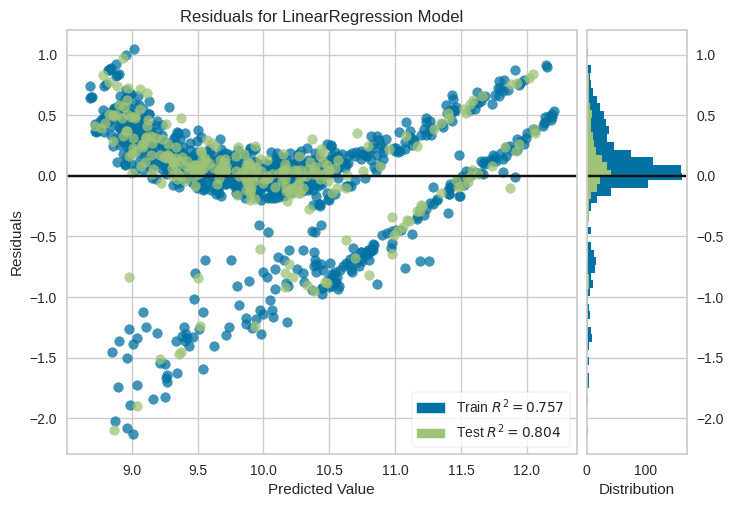

<Axes: title={'center': 'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [77]:
# 9.1. Transform the DV using log transformation
y_train_transformed = np.log(y_train)
y_test_transformed = np.log(y_test)

model = LinearRegression()
visualizer = ResidualsPlot(model)

visualizer.fit(X_train, y_train_transformed)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test_transformed)  # Evaluate the model on the test data
visualizer.show()

**Observations:**
- Residuals appear to be more randomly distributed; however, there are some persisting outliers.
- The R-squared metrics of both train and test set increase after the data transformation, indicating better performance of the model.

**Approach 3:**
Since the residual plot suggests there are non-linear relationships that the least squares model cannot capture, we consider using generalized linear model, starting with Gamma Regressor as the response value is non-negative and shows skewed distribution. This approach assumes the distribution of the response term follows the Gamma distribution. However, it doesn't seem to show a good performance in fitting the data.

In [88]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [89]:
import statsmodels.api as sm
from statsmodels.genmod.families import Gamma
from statsmodels.genmod.families.links import log

# Initialize and fit the model
X_train_scaled_sm = sm.add_constant(X_train_scaled)
gamma_model = sm.GLM(y_train, X_train_scaled_sm, family=Gamma(link=log()))
gamma_results = gamma_model.fit()

# Print the summary of the model
print(gamma_results.summary())


                    Generalized Linear Model Regression Results                    
Dep. Variable:     hospitalization charges   No. Observations:                 1070
Model:                                 GLM   Df Residuals:                     1061
Model Family:                        Gamma   Df Model:                            8
Link Function:                         log   Scale:                         0.45910
Method:                               IRLS   Log-Likelihood:                -11638.
Date:                     Sun, 05 Jan 2025   Deviance:                       274.29
Time:                             04:08:42   Pearson chi2:                     487.
No. Iterations:                         18   Pseudo R-squ. (CS):             0.6743
Covariance Type:                 nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
co

/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


In [94]:
from sklearn.linear_model import GammaRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Initialize and fit the Gamma Regressor
gamma_regressor = GammaRegressor(max_iter=1000)
gamma_regressor.fit(X_train_scaled, y_train)

# Print coefficients
print("Intercept:", gamma_regressor.intercept_)
print("Coefficients:", gamma_regressor.coef_)

# Predictions
y_test_pred = gamma_regressor.predict(X_test_scaled)




Intercept: 10.222218268715674
Coefficients: [ 0.16448409  0.06448967  0.03797849 -0.00144381  0.2989011  -0.00443679
  0.00115239 -0.01579783]


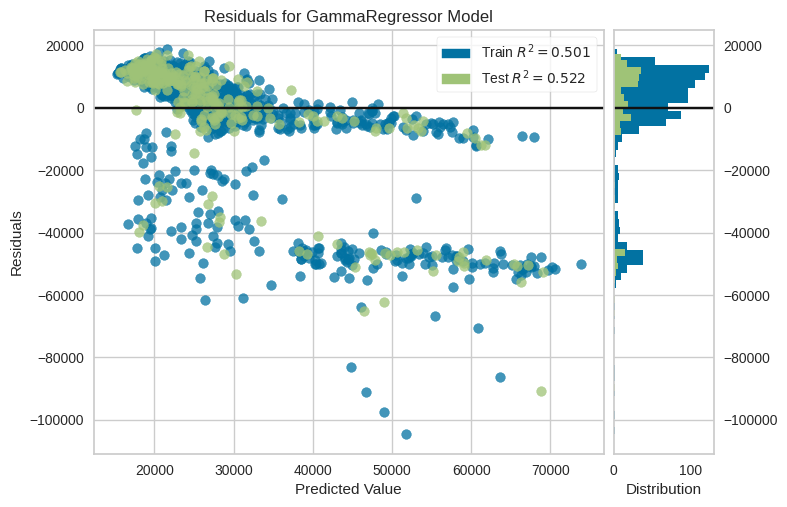

<Axes: title={'center': 'Residuals for GammaRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [92]:
# 6. Examine distribution of residuals to verify the assumption
visualizer = ResidualsPlot(gamma_regressor)

visualizer.fit(X_train_scaled, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test_scaled, y_test)  # Evaluate the model on the test data
visualizer.show()

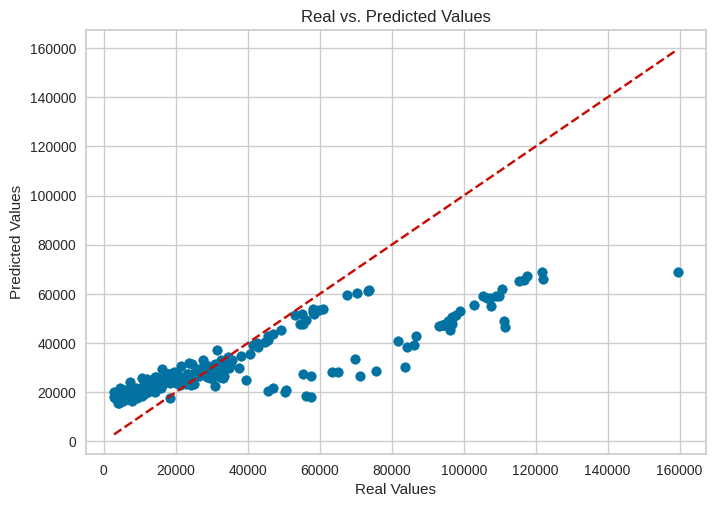

In [95]:
# Plot real vs. predicted response values
plt.scatter(y_test, y_test_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.title('Real vs. Predicted Values')
plt.show()

Approach 4: Using Random Forest to find most important features. Top 3 most important features, in order, are smoker, viral load, and age.

In [99]:
# Using Random Forest to find most important features
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=1000, random_state=42)
rf_model.fit(X_train, y_train)

r2_score = rf_model.score(X_test, y_test)
print(f"R-squared on test set: {r2_score}")

# Get feature importances from the trained Random Forest model
feature_importances = rf_model.feature_importances_

# Create a DataFrame to display feature names and their importance
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)


R-squared on test set: 0.8634357774257844
            Feature  Importance
4    smoker_encoded    0.609483
1        viral load    0.214551
0               age    0.134605
2    severity level    0.019690
3       sex_encoded    0.006571
6  region_southeast    0.005471
5  region_northwest    0.005394
7  region_southwest    0.004234


**Question 1 - Conclusion:** It was shown above that region is not an important feature in predicting the hospitalization charge, therefore, we can safely conlcude that there is no significant difference in the impact of other predictors between different regions.